# 1.) Plot the felicity function

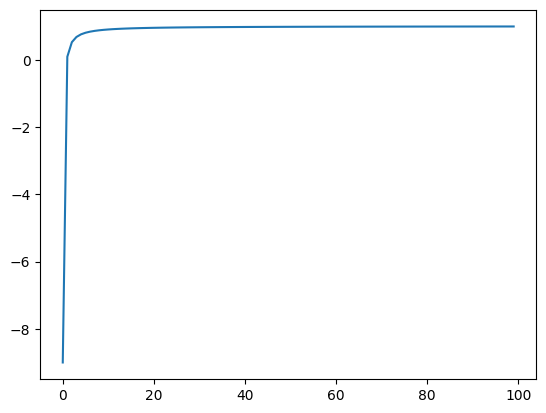

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def u(c):
    return(1-c**(-1))
x=np.arange(0.1,100)
plt.plot(u(x))

# The asset pricing formula is

$$

q(s)\;=\;\beta\,\frac{m_{s1}\,u{\prime}(c(s_1))\,r_1 \;+\;m_{s2}\,u{\prime}(c(s_2))\,r_2}{u{\prime}(c(s))}.

$$

where $m_{si}$ is the relevant element of the Markov matrix $M$.

# The asset price in each state

In [6]:
q1 = (0.8*1**(-2) + 0.2*(1.05)**(-2))/1**(-2)
q2 = (0.1*1**(-2) + 0.9*(1.05)**(-2))/1.05**(-2)
print("The asset price in each state is",  q1,q2)

The asset price in each state is 0.9814058956916101 1.0102499999999999


# Ergodic distribution from first principles

I'll just use the first equation.  $ 0.8 \pi_1 + 0.1 \pi_2 = \pi_1$ implies that $\pi_2 = 2 \pi_1$.  The two numbers are probabilities.  So $\pi_1 = 1/3$ and $\pi_2= 2/3$.

# Expected long-run price of the asset

In [10]:
print("The expected price of the asset in the long run is", q1/3+2*q2/3)

The expected price of the asset in the long run is 1.00063529856387


# 2.) Time Series Problem
(REPLACE WITH YOUR FILE PATH TO RUN)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

#replace with your file path 
file_path = "/Users/jadenfix/Desktop/Graduate School Materials/stochastic/time_series_midterm_2025.xlsx"
df = pd.read_excel(file_path)

# Display the first few rows to check the import
print(df.head())

         x1        x2        x3        x4
0  0.647689  0.677899  0.647689  0.647689
1  1.911643  1.819221  2.170718  2.105950
2  0.718526  0.656899  1.936565  1.661201
3 -0.376514 -0.046608  1.702428  1.260944
4  1.137746  1.415314  3.281641  2.714063


# Graph the four time series

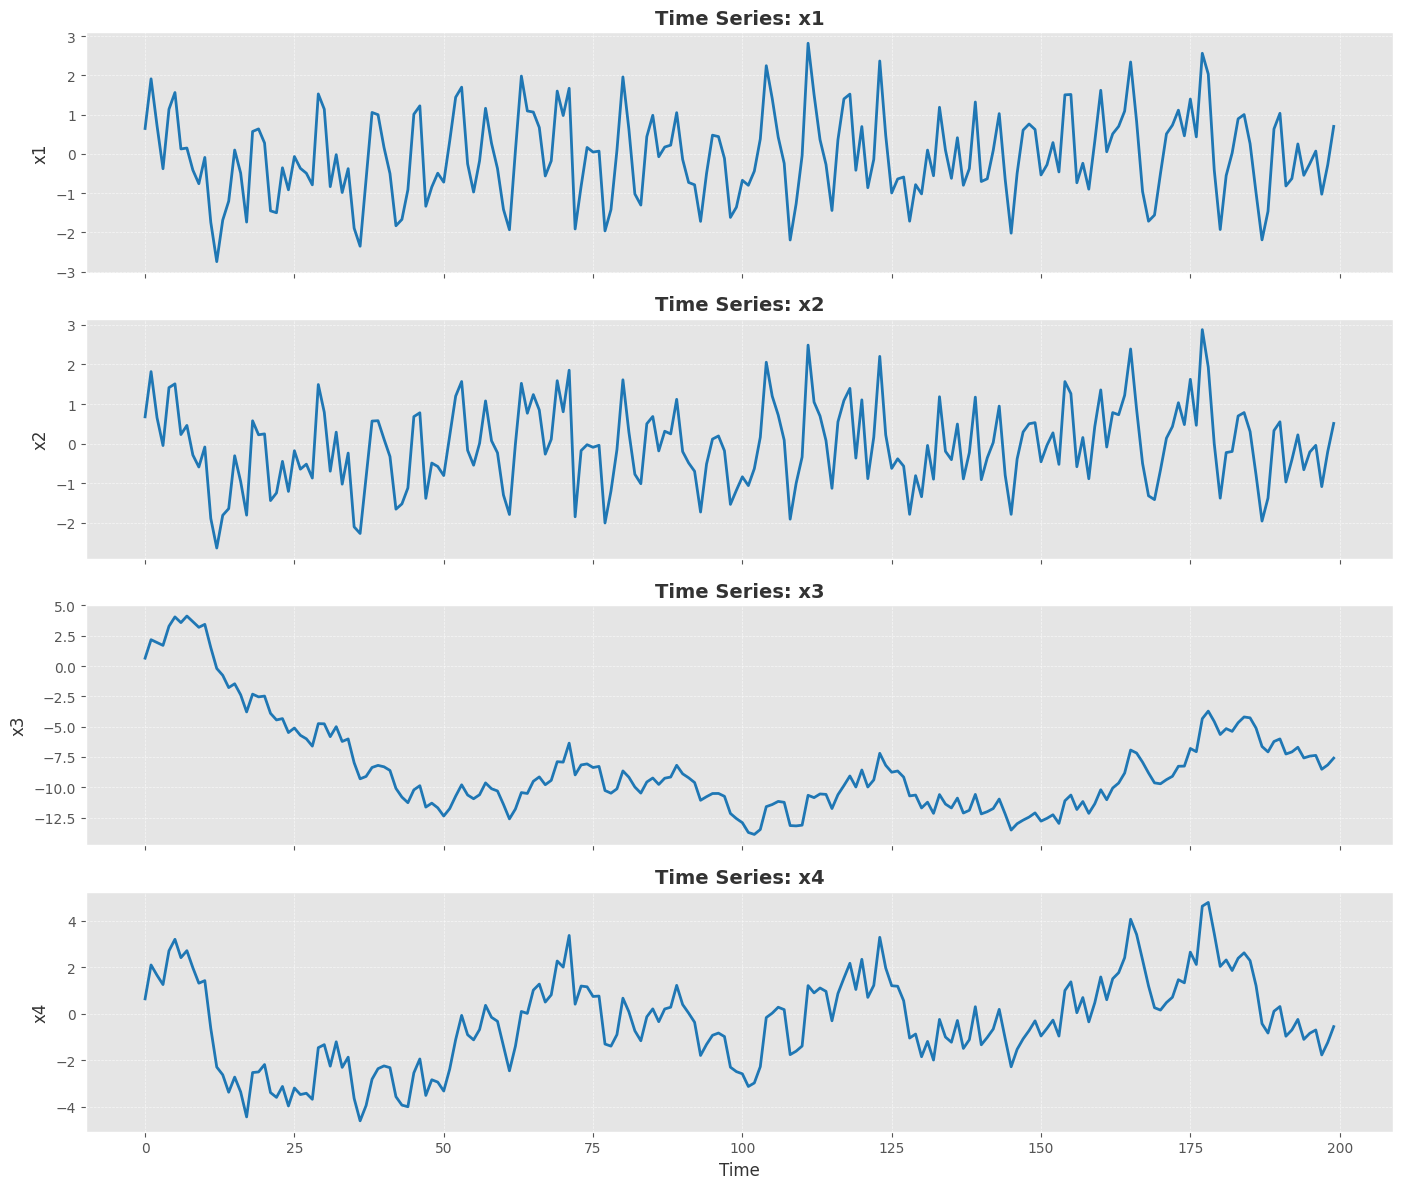

In [9]:
preferred_styles = ["seaborn-whitegrid", "seaborn", "ggplot"]
for style in preferred_styles:
    if style in plt.style.available:
        plt.style.use(style)
        break
else:
    plt.style.use("default")

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col], color="#1f77b4", lw=2)
    axes[i].set_title(f"Time Series: {col}", fontsize=14, fontweight="bold", color="#333333")
    axes[i].set_ylabel(col, fontsize=12, color="#333333")
    axes[i].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

axes[-1].set_xlabel("Time", fontsize=12, color="#333333")
plt.tight_layout()
plt.show()

# Auto-correlograms with 20 lags

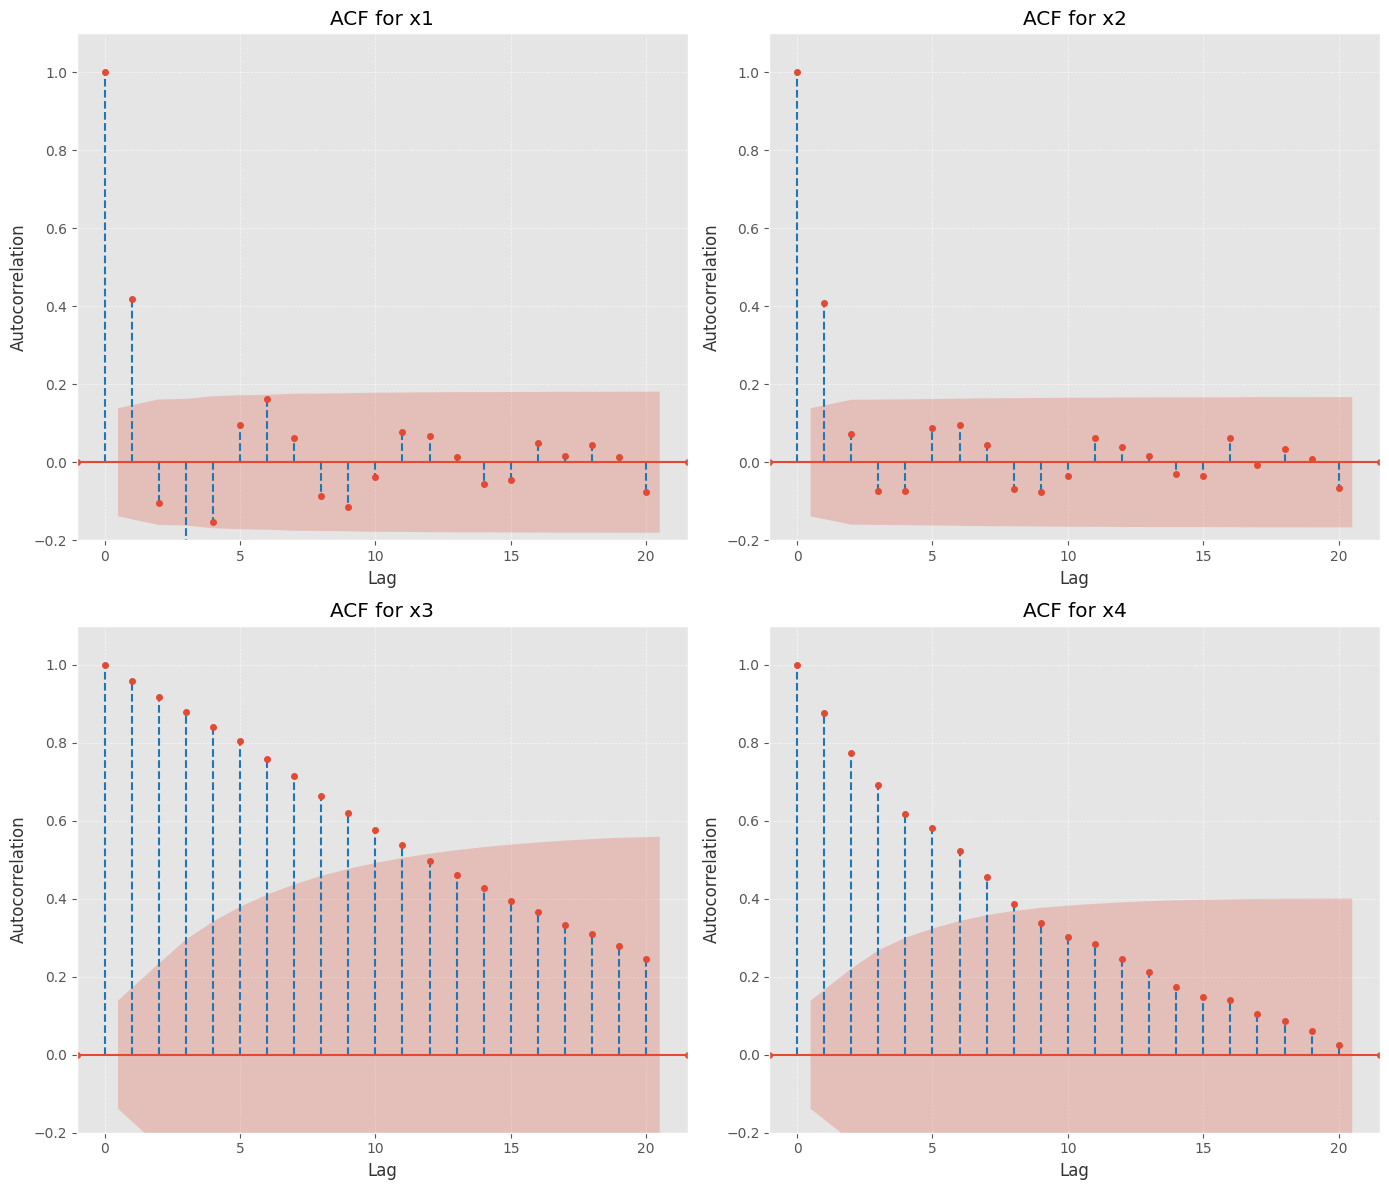


IDENTIFICATION (Based on ACF Patterns):
--------------------------------------
- AR(2): The ACF often decays gradually (possibly with some oscillation).
- MA(2): The ACF cuts off after lag 2 (little to no correlation beyond lag 2).
- AR(1): The ACF decays exponentially, with strongest correlation at lag 1.
- Random Walk: The ACF declines very slowly (roughly linear downward slope).



In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    plot_acf(
        df[col],
        lags=20,
        ax=axes[i],
        title=f"ACF for {col}",
        vlines_kwargs={"colors": "#1f77b4", "linestyle": "--", "linewidth": 1.5},
        marker="o",
        markersize=4
    )
    axes[i].set_ylim(-0.2, 1.1)
    axes[i].set_xlabel("Lag", fontsize=12, color="#333333")
    axes[i].set_ylabel("Autocorrelation", fontsize=12, color="#333333")
    axes[i].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

print("""
IDENTIFICATION (Based on ACF Patterns):
--------------------------------------
- AR(2): The ACF often decays gradually (possibly with some oscillation).
- MA(2): The ACF cuts off after lag 2 (little to no correlation beyond lag 2).
- AR(1): The ACF decays exponentially, with strongest correlation at lag 1.
- Random Walk: The ACF declines very slowly (roughly linear downward slope).
""")

# 1. Estimate AR2 process, using MLE and imposing that $ \sigma^2 = 1$

In [16]:

models = {
    "x1": {"order": (2, 0, 0)},  # AR(2)
    "x2": {"order": (0, 0, 2)},  # MA(2)
    "x3": {"order": (1, 0, 0)},  # AR(1)
    "x4": {"order": (0, 1, 0)}   # Random Walk
}

results = {}

for col in df.columns:
    print(f"\n--- Results for {col} ---")
    order = models[col]["order"]
    
    # If the series is Random Walk (ARIMA(0,1,0)), there's no AR or MA parameter.
    if order == (0, 1, 0):
        print("Model: Random Walk (ARIMA(0,1,0))")
        print("No parameters to estimate (unit root).")
        continue
    
    # Fit ARIMA with no constant term
    model = ARIMA(df[col], order=order, trend="n")
    result = model.fit()
    results[col] = result
    
    print(result.summary())

Estimated Parameters: phi1 = 0.5590243438707172, phi2 = -0.33604828446283547
Standard Errors: SE(phi1) = 0.06653198217429408, SE(phi2) = 0.06648369155227284


# 2. Estimate MA2 process, using MLE and imposing that $σ^2 = 1$

In [18]:
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import inv

def ma2_log_likelihood(params, data):
    theta1, theta2 = params
    n = len(data)
    
    # Initialize the series for residuals
    residuals = np.zeros(n)
    
    # Compute the residuals based on MA(2) model
    for t in range(2, n):
        residuals[t] = data[t] - (theta1 * residuals[t-1] + theta2 * residuals[t-2])

    # Negative log-likelihood
    #nll = 0.5 * n * np.log(2 * np.pi * sigma2) + (1 / (2 * sigma2)) * np.sum(residuals[2:] ** 2)
    nll =  np.sum(residuals[2:] ** 2)
    return nll

def optimize_ma2(data):
    initial_params = [0.1, 0.1]  # Smaller initial guesses for theta1 and theta2

    result = minimize(ma2_log_likelihood, initial_params, args=(data,))

    if result.success:
        return result.x  # returns optimized parameters
    else:
        raise ValueError("Optimization failed.")


def calculate_standard_errors(params, data):
    theta1, theta2 = params
    n = len(data)

    # Calculate residuals based on the optimized parameters
    residuals = np.zeros(n)
    for t in range(2, n):
        residuals[t] = data[t] - (theta1 * residuals[t-1] + theta2 * residuals[t-2])

    # Calculate RSS to estimate the variance
    RSS = np.sum(residuals[2:] ** 2)  # Residual sum of squares
    var_y = RSS / (n - 2)  # Use n - 2 for degrees of freedom

    # Hessian calculation for standard errors
    H = np.zeros((2, 2))
    for i in range(2, n):
        H[0, 0] += residuals[i-1]**2 
        H[0, 1] += residuals[i-1] * residuals[i-2] 
        H[1, 0] += residuals[i-1] * residuals[i-2] 
        H[1, 1] += residuals[i-2]**2

    # Inverse Hessian for calculating standard errors
    cov_params = var_y * inv(H)
    standard_errors = np.sqrt(np.diag(cov_params))

    return standard_errors

# Optimize MA(2) model parameters with variance constrained to 1
optimized_params = optimize_ma2(x2)
theta1, theta2 = optimized_params

# Calculate standard errors of the estimates
standard_errors = calculate_standard_errors(optimized_params, x2)

# Output estimated parameters and their standard errors
print(f"Estimated Parameters: theta1 = {theta1}, theta2 = {theta2}")
print(f"Standard Errors: SE(theta1) = {standard_errors[0]}, SE(theta2) = {standard_errors[1]}")

Estimated Parameters: theta1 = 0.44231166182748777, theta2 = 0.8775495561241402
Standard Errors: SE(theta1) = 0.07109545396171521, SE(theta2) = 0.07112609895782554


# 3. The third series obviously has the unit root.  One does not even need an ADF test.

# 4. Estimate AR1 process, using MLE and imposing that $\sigma^2 = 1$


In [21]:
def ar1_log_likelihood(params, data):
    phi1, sigma2 = params
    n = len(data)
    
    # Initialize the series with zeros
    residuals = np.zeros(n)
    # Compute residuals based on AR(2) model
    for t in range(2, n):
        residuals[t] = data[t] - phi1 * data[t-1]
    
    # Negative log-likelihood: NLL = - sum of log(pdf)
    nll = 0.5 * n * np.log(2 * np.pi * sigma2) + (1 / (2 * sigma2)) * np.sum(residuals**2)
    return nll

def optimize_ar1(data):
    # Initial guesses for parameters: phi1, phi2, and sigma2
    initial_params = [0.1, 1]  # sigma2 starts at 1 due to constraint
    
    # Constraint for variance: fixed at 1
    constraints = ({'type': 'eq', 'fun': lambda params: params[1] - 1})
    
    result = minimize(ar1_log_likelihood, initial_params, args=(data,), constraints=constraints)
    
    if result.success:
        return result.x  # returns optimized parameters
    else:
        raise ValueError("Optimization failed.")


# Optimize AR(1) model parameters with variance constrained to 1
optimized_params = optimize_ar1(x4)
phi1, sigma2 = optimized_params

def calculate_standard_errors(params, data):
    phi1, sigma2 = params  # sigma2 is fixed to 1
    n = len(data)

    # Calculate residuals based on the optimized parameters
    residuals = np.zeros(n)
    for t in range(2, n):
        residuals[t] = data[t] - phi1 * data[t-1] 

    # Calculate RSS to estimate the variance
    RSS = np.sum(residuals[2:] ** 2)  # Residual sum of squares
    var_y = RSS / (n - 2)  # Use n - 2 for degrees of freedom

    # Hessian calculation for standard errors
    H = np.zeros((1, 1))
    for i in range(1, n):
        H[0, 0] += data[i-1]**2 / sigma2

    # Inverse Hessian for calculating standard errors
    cov_params = var_y * inv(H)
    standard_errors = np.sqrt(np.diag(cov_params))

    return standard_errors

standard_errors = calculate_standard_errors(optimized_params, x4)

# Output estimated parameters and their standard errors
print(f"Estimated Parameters: phi1 = {phi1}")
print(f"Standard Errors: SE(phi1) = {standard_errors[0]}")

Estimated Parameters: phi1 = 0.8788340155890353
Standard Errors: SE(phi1) = 0.03349358872168264


# Correlogram for the random walk
The covariance between $X_t$ and $X_{t+k}$ only depends upon all the error terms $\epsilon_0, \dots, \epsilon_t$.  The terms $\epsilon_{t+1}, \dots, \epsilon_{t+k}$ are uncorrelated with everything that went before.  So this correlation decreases linearly as $k$ grows larger.  Thus the correlation as a function of the lags slopes down like a straight line in a sample with finitely many observations.